# IDENTIFY BEST VARIETIES AND DOMINANT SOW BASED ON SIMULATED YIELD

In [ ]:
"""
This work is done by R script: 
4.1_MzSg_ExtractSimOuput.R - Extract yearly yield from simulation (12month) based on sow assumptions
4.2_MzSg_ComputeSI.R - Indentify optimum variety based on SI (Sustainability Index)
   Sow: All Computations are based on simulation with Optimum Sow Month.
   SI: We compute the SI for all arable cells in period, either primary and minor season, when 
their chance to obtain a sustainable yield (defined as yield greater than 1t/ha) is greater than 80%.
   Area: We use physical maize are of 2020 to weighted average the SI for the continent. The area is 
also applied to minor season maize, whereever there is an estimated SI. 
.
Plotting:
a. Temporal change of SI of the three maturity groups over the past five decades for primary maize
b. Temporal change of area share of the three groups for primary season maize
c. SI for the minor season maize
d. area share for the minor season maize
"""

In [1]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [4]:
fer="wfer_wa38hi40"
G1="" #or _G1 #if remove grids that over >80% yearly yield is less than 1

In [ ]:
#Here need to run the R script for generating the cultivar distribution

In [5]:
#Compute the aggregated and yearly yield for estimating the SI - 
#Only the primary season is compared because crop area of the minor season is limted, and the  minor season depends on the 
#time of primiary season.
#cell yearly yield
in_dir="D:/works/AfricaMzSg/output/"
sw=["ReportedSow","OptimumFixedSow"]
#Maize physical area
area=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SIMUNIT_MZ_PhysicalArea.csv")
yld=pd.DataFrame(columns=['sowtype','matu','sea','GT1']+[str(yr) for yr in range(1971,2022)])
for sow in sw:
    df0=pd.read_csv(in_dir+"mz_yield_"+sow+"_"+fer+".txt",delim_whitespace=True)  #Change here when you want to use wofer yield
    for cul in [1,2,3]: #three varieties
        for sea in [1]: #two seasons only the first season because the sowing month identifed by peaks is not feasible
            df=df0[(df0['matu']==cul)&(df0['sea']==sea)].fillna(0).reset_index()
            df=df.merge(area,how='left').fillna(0)
            #not GT1
            yld.loc[len(yld)+1,]=[sow,cul,sea,0]+list((np.dot(df[['PhysicalArea']].values.T,
                                                df[["yld_"+str(yr) for yr in range(1971,2022)]].values)/df['PhysicalArea'].sum()).flatten()) 
            #yes GT1
            #Only consider the cells whose chance of obtaining subsistent yield (>1t/ha) is greater than 80%.
            df['G1count']=[(df.loc[i,["yld_"+str(yr) for yr in range(1971,2022)]]>=1).sum() for i in df.index]
            df=df[df.G1count>=(51*0.8)] #only keep rows that >80% years yield greater 1
            yld.loc[len(yld)+1,]=[sow,cul,sea,1]+list((np.dot(df[['PhysicalArea']].values.T,
                                                df[["yld_"+str(yr) for yr in range(1971,2022)]].values)/df['PhysicalArea'].sum()).flatten())
yld.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+"\\mz_aggregatedAfricanYield_"+fer+".csv", index=False)

# Plotting for SI of cultivar in Africa and its changes over the five decades

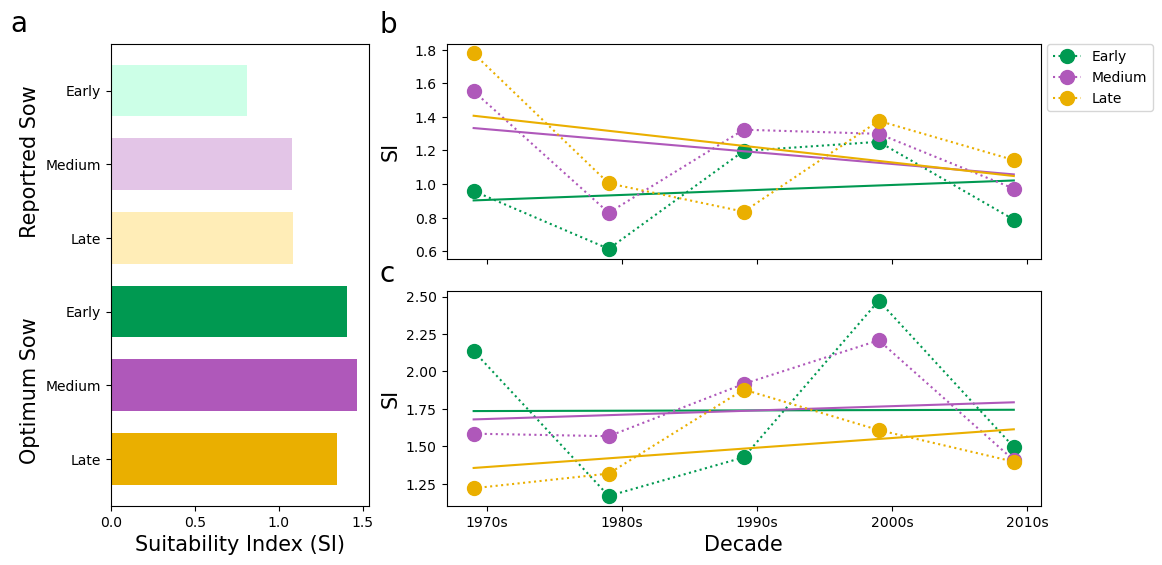

In [21]:
yld=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+"\\mz_aggregatedAfricanYield_"+fer+".csv")
yld['SI']=yld[[str(yr) for yr in range(1971,2022)]].mean(axis=1)**2/(100*yld[[str(yr) for yr in range(1971,2022)]].std(axis=1))
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\wfer\\"
fig = plt.figure(figsize=(12,6))  #,width_ratios=[0.5,1]
gs=fig.add_gridspec(2,3)

ax1=fig.add_subplot(gs[0:2,0])
df=yld[yld['GT1']==0]    #Do not remove grid that over 80% years yield is greater than 1
#SI for Africa
data={
    'SI': df['SI'].tolist(),  #Values for the six bars 
    'BarWidth': [0.7,0.7,0.7,0.7,0.7,0.7],
    'Color': ['#CCFFE7','#E3C5E7','#FFEDB7','#009951','#AF58BA','#EAAF00']
}
type_colors=[['#CCFFE7','#E3C5E7','#FFEDB7'],['#009951','#AF58BA','#EAAF00']] #Green, purple, pink
type_lines=[':',"-"]
#Green:#CCFFE7,#009951 Purple: #E3C5E7 #AF58BA Pink #FFEDB7 #EAAF00
label=['Early','Medium','Late']

y_p=[5,4,3,2,1,0]
for i,(value,width,color) in enumerate(zip(data['SI'],data['BarWidth'],data['Color'])):
    ax1.barh(y_p[i],value,height=width,color=color)
    #axes[0].text(value-value/1.5,y_p[i]-0.1,label[i])
ax1.set_yticks([0,1,2,3,4,5],['Late','Medium','Early','Late','Medium','Early'])
ax1.set_ylabel('Optimum Sow            Reportred Sow',fontsize=15)
ax1.set_xlabel('Suitability Index (SI)',fontsize=15)

#For decades
ax2=fig.add_subplot(gs[0,1:3])
sow=0
for cul in range(3):
    #SI Change  - yld
    y = df.loc[(df.matu==cul+1)&(df.sowtype==sw[sow]),[str(x) for x in range(1971,2022)]]
    y = pd.DataFrame(y.values[0])
    if sow==1: y=y-4
    #plt.plot()
    y = (y[0].groupby(np.arange(len(y)) // 10).mean())**2/(100*y[0].groupby(np.arange(len(y)) // 10).std())
    y = y.dropna()
    x = list(range(1975,2021,10))
    ax2.plot(x,y,marker='o',markersize=10,color=type_colors[1][cul],linestyle=":",label=label[cul]) #,
    #trend
    z = np.polyfit(x,y,1) #fit a 1st-degree polynomial (linear)
    p = np.poly1d(z)
    ax2.plot(x, p(x), "-", color=type_colors[1][cul])
    ax2.set_xticks([1976,1986,1996,2006,2016])
    ax2.set_xticklabels([])
    ax2.set_ylabel("SI",fontsize=15,labelpad=10)

ax3=fig.add_subplot(gs[1,1:3])
sow=1
for cul in range(3):
    #SI Change  - yld
    y = df.loc[(df.matu==cul+1)&(df.sowtype==sw[sow]),[str(x) for x in range(1971,2022)]]
    y = pd.DataFrame(y.values[0])
    #plt.plot()
    y = (y[0].groupby(np.arange(len(y)) // 10).mean())**2/(100*y[0].groupby(np.arange(len(y)) // 10).std())
    y = y.dropna()
    x = list(range(1975,2021,10))
    ax3.plot(x,y,marker='o',markersize=10,color=type_colors[sow][cul],linestyle=":") #,
    #trend
    z = np.polyfit(x,y,1) #fit a 1st-degree polynomial (linear)
    p = np.poly1d(z)
    ax3.plot(x, p(x), "-", color=type_colors[sow][cul])
    ax3.set_xticks([1976,1986,1996,2006,2016])
    ax3.set_xticklabels(["1970s","1980s","1990s","2000s","2010s"])
    ax3.set_xlabel("Decade",fontsize=15)
    ax3.set_ylabel("SI",fontsize=15)
    ax3.tick_params(axis='both', which='major')
ax2.legend(bbox_to_anchor=(1.2, 1.03), loc='upper right',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.30, hspace=0.15)
ax1.text(-0.6,5.8,'a',fontsize=20)
ax2.text(1968,1.9,'b',fontsize=20)
ax3.text(1968,2.6,'c',fontsize=20)
fig.savefig(fig_dir+"\\M1_SIandItsChangeOverTimes_"+fer+".png",format="png",dpi=300, bbox_inches='tight', pad_inches=0)

In [20]:
yld[yld.GT1==0][['sowtype','matu','SI']]#.groupby('sowtype').mean()

,sowtype,matu,SI
0,ReportedSow,1,0.812248
2,ReportedSow,2,1.080163
4,ReportedSow,3,1.084977
6,OptimumFixedSow,1,1.404265
8,OptimumFixedSow,2,1.464346
10,OptimumFixedSow,3,1.344479


In [17]:
(1.404363-0.992463)*100/0.992463

41.50280665374932

In [53]:
#test the significence of SI change for the early maturity maize
cul=2  #early
y = df.loc[(df.matu==cul+1)&(df.sowtype=="OptimumFixedSow"),[str(x) for x in range(1971,2022)]]
y = pd.DataFrame(y.values[0])
#if sow==1: y=y-4
#plt.plot()
y = (y[0].groupby(np.arange(len(y)) // 10).mean())**2/(100*y[0].groupby(np.arange(len(y)) // 10).std())
y = y.dropna()
x = list(range(1975,2021,10))
x=sm.add_constant(x)
model=sm.OLS(y,x)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                 -0.132
Method:                 Least Squares   F-statistic:                    0.5325
Date:                Sun, 27 Apr 2025   Prob (F-statistic):              0.518
Time:                        09:06:41   Log-Likelihood:                0.55088
No. Observations:                   5   AIC:                             2.898
Df Residuals:                       3   BIC:                             2.117
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.3961     17.652     -0.646      0.5

D:\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [ ]:
#Plots by removing grids that the chance of yield is greater than 0.8

Text(1969, 3.4, 'c')

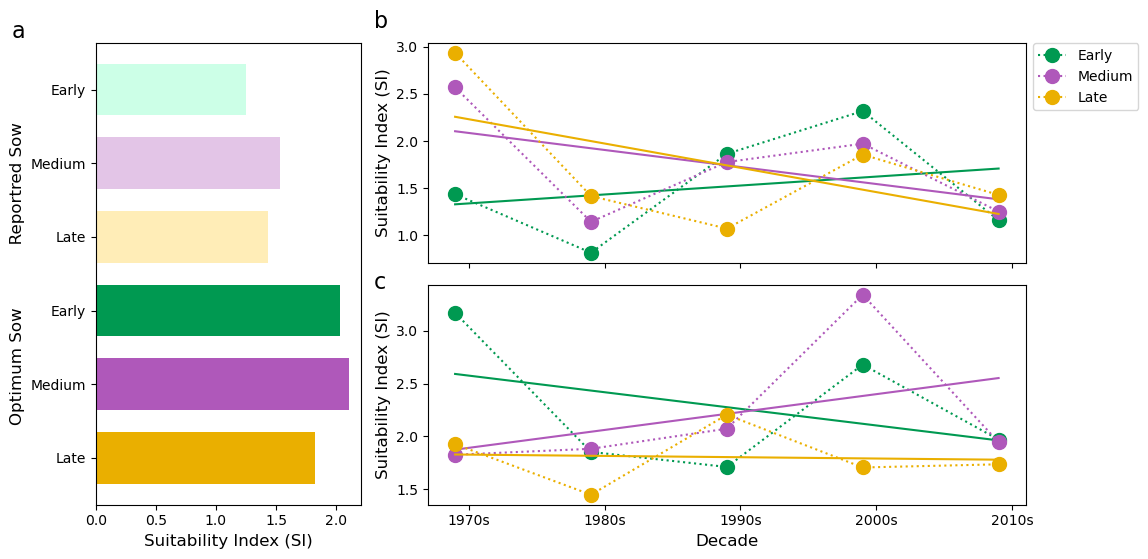

In [137]:
yld=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+"\\mz_aggregatedAfricanYield_"+fer+".csv")
yld['SI']=yld[[str(yr) for yr in range(1971,2022)]].mean(axis=1)**2/(100*yld[[str(yr) for yr in range(1971,2022)]].std(axis=1))
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\wfer\\"
fig = plt.figure(figsize=(12,6))  #,width_ratios=[0.5,1]
gs=fig.add_gridspec(2,3)

ax1=fig.add_subplot(gs[0:2,0])
df=yld[yld['GT1']==1]    #Do not remove grid that over 80% years yield is greater than 1
#SI for Africa
data={
    'SI': df['SI'].tolist(),  #Values for the six bars 
    'BarWidth': [0.7,0.7,0.7,0.7,0.7,0.7],
    'Color': ['#CCFFE7','#E3C5E7','#FFEDB7','#009951','#AF58BA','#EAAF00']
}
type_colors=[['#CCFFE7','#E3C5E7','#FFEDB7'],['#009951','#AF58BA','#EAAF00']] #Green, purple, pink
type_lines=[':',"-"]
#Green:#CCFFE7,#009951 Purple: #E3C5E7 #AF58BA Pink #FFEDB7 #EAAF00
label=['Early','Medium','Late']

y_p=[5,4,3,2,1,0]
for i,(value,width,color) in enumerate(zip(data['SI'],data['BarWidth'],data['Color'])):
    ax1.barh(y_p[i],value,height=width,color=color)
    #axes[0].text(value-value/1.5,y_p[i]-0.1,label[i])
ax1.set_yticks([0,1,2,3,4,5],['Late','Medium','Early','Late','Medium','Early'])
ax1.set_ylabel('Optimum Sow            Reportred Sow',fontsize=12)
ax1.set_xlabel('Suitability Index (SI)',fontsize=12)

#For decades
ax2=fig.add_subplot(gs[0,1:3])
sow=0
for cul in range(3):
    #SI Change  - yld
    y = df.loc[(df.matu==cul+1)&(df.sowtype==sw[sow]),[str(x) for x in range(1971,2022)]]
    y = pd.DataFrame(y.values[0])
    if sow==1: y=y-4
    #plt.plot()
    y = (y[0].groupby(np.arange(len(y)) // 10).mean())**2/(100*y[0].groupby(np.arange(len(y)) // 10).std())
    y = y.dropna()
    x = list(range(1975,2021,10))
    ax2.plot(x,y,marker='o',markersize=10,color=type_colors[1][cul],linestyle=":",label=label[cul]) #,
    #trend
    z = np.polyfit(x,y,1) #fit a 1st-degree polynomial (linear)
    p = np.poly1d(z)
    ax2.plot(x, p(x), "-", color=type_colors[1][cul])
    ax2.set_xticks([1976,1986,1996,2006,2016])
    ax2.set_xticklabels([])
    ax2.set_ylabel("Suitability Index (SI)",fontsize=12)

ax3=fig.add_subplot(gs[1,1:3])
sow=1
for cul in range(3):
    #SI Change  - yld
    y = df.loc[(df.matu==cul+1)&(df.sowtype==sw[sow]),[str(x) for x in range(1971,2022)]]
    y = pd.DataFrame(y.values[0])
    #plt.plot()
    y = (y[0].groupby(np.arange(len(y)) // 10).mean())**2/(100*y[0].groupby(np.arange(len(y)) // 10).std())
    y = y.dropna()
    x = list(range(1975,2021,10))
    ax3.plot(x,y,marker='o',markersize=10,color=type_colors[sow][cul],linestyle=":") #,
    #trend
    z = np.polyfit(x,y,1) #fit a 1st-degree polynomial (linear)
    p = np.poly1d(z)
    ax3.plot(x, p(x), "-", color=type_colors[sow][cul])
    ax3.set_xticks([1976,1986,1996,2006,2016])
    ax3.set_xticklabels(["1970s","1980s","1990s","2000s","2010s"])
    ax3.set_xlabel("Decade",fontsize=12)
    ax3.set_ylabel("Suitability Index (SI)",fontsize=12)
    ax3.tick_params(axis='both', which='major')
ax2.legend(bbox_to_anchor=(1.2, 1.03), loc='upper right',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.1)
ax1.text(-0.7,5.7,'a',fontsize=16)
ax2.text(1969,3.2,'b',fontsize=16)
ax3.text(1969,3.4,'c',fontsize=16)
#fig.savefig(fig_dir+"\\M1_SIandItsChangeOverTimes.png",format="png",dpi=300, bbox_inches='tight', pad_inches=0)

In [56]:
fer="wofer_wa38hi40"
G1="_G1" #or _G1 #if remove grids that over >80% yearly yield is less than 1
#Compute the aggregated and yearly yield for estimating the SI - 
#Only the primary season is compared because crop area of the minor season is limted, and the  minor season depends on the 
#time of primiary season.
#cell yearly yield
in_dir="D:/works/AfricaMzSg/output/"
sw=["ReportedSow","OptimumFixedSow"]
#Maize physical area
area=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SIMUNIT_MZ_PhysicalArea.csv")
yld=pd.DataFrame(columns=['sowtype','matu','sea','GT1']+[str(yr) for yr in range(1971,2022)])
for sow in sw:
    df0=pd.read_csv(in_dir+"mz_yield_"+sow+"_"+fer+".txt",delim_whitespace=True)  #Change here when you want to use wofer yield
    for cul in [1,2,3]: #three varieties
        for sea in [1]: #two seasons only the first season because the sowing month identifed by peaks is not feasible
            df=df0[(df0['matu']==cul)&(df0['sea']==sea)].fillna(0).reset_index()
            df=df.merge(area,how='left').fillna(0)
            #not GT1
            yld.loc[len(yld)+1,]=[sow,cul,sea,0]+list((np.dot(df[['PhysicalArea']].values.T,
                                                df[["yld_"+str(yr) for yr in range(1971,2022)]].values)/df['PhysicalArea'].sum()).flatten()) 
            #yes GT1
            #Only consider the cells whose chance of obtaining subsistent yield (>1t/ha) is greater than 80%.
            df['G1count']=[(df.loc[i,["yld_"+str(yr) for yr in range(1971,2022)]]>=1).sum() for i in df.index]
            df=df[df.G1count>=(51*0.8)] #only keep rows that >80% years yield greater 1
            yld.loc[len(yld)+1,]=[sow,cul,sea,1]+list((np.dot(df[['PhysicalArea']].values.T,
                                                df[["yld_"+str(yr) for yr in range(1971,2022)]].values)/df['PhysicalArea'].sum()).flatten())
yld.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+"\\mz_aggregatedAfricanYield_"+fer+".csv", index=False)

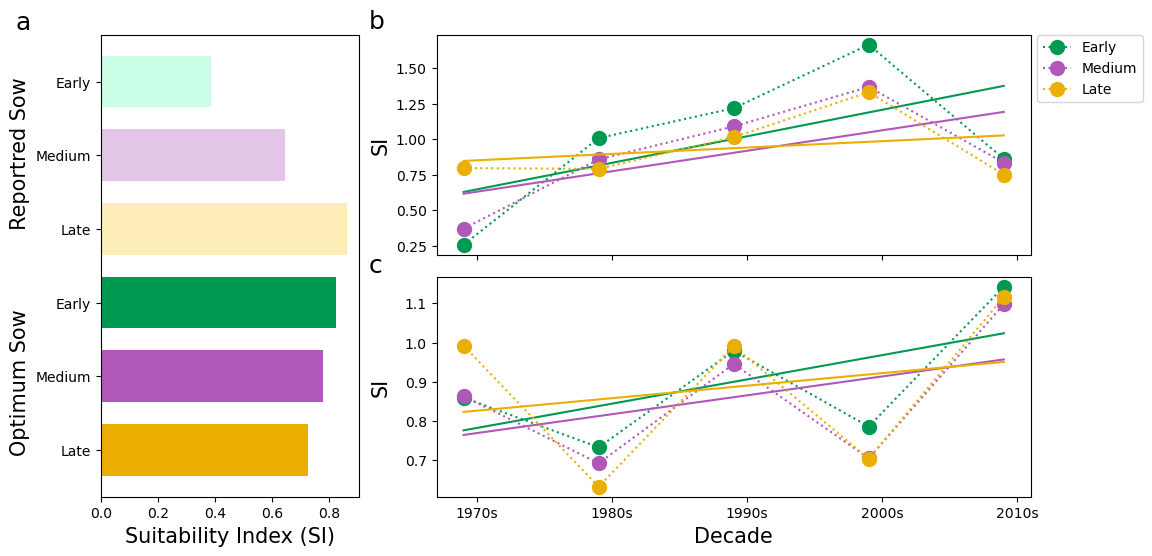

In [71]:
#Plots for simulation without fertilization
fer="wofer_wa38hi40"
G1="_G1" #or _G1 #if remove grids that over >80% yearly yield is less than 1
yld=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+"\\mz_aggregatedAfricanYield_"+fer+".csv")
yld['SI']=yld[[str(yr) for yr in range(1971,2022)]].mean(axis=1)**2/(100*yld[[str(yr) for yr in range(1971,2022)]].std(axis=1))
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\wfer\\"
fig = plt.figure(figsize=(12,6))  #,width_ratios=[0.5,1]
gs=fig.add_gridspec(2,3)

ax1=fig.add_subplot(gs[0:2,0])
df=yld[yld['GT1']==0]    #Do not remove grid that over 80% years yield is greater than 1
#SI for Africa
data={
    'SI': df['SI'].tolist(),  #Values for the six bars 
    'BarWidth': [0.7,0.7,0.7,0.7,0.7,0.7],
    'Color': ['#CCFFE7','#E3C5E7','#FFEDB7','#009951','#AF58BA','#EAAF00']
}
type_colors=[['#CCFFE7','#E3C5E7','#FFEDB7'],['#009951','#AF58BA','#EAAF00']] #Green, purple, pink
type_lines=[':',"-"]
#Green:#CCFFE7,#009951 Purple: #E3C5E7 #AF58BA Pink #FFEDB7 #EAAF00
label=['Early','Medium','Late']

y_p=[5,4,3,2,1,0]
for i,(value,width,color) in enumerate(zip(data['SI'],data['BarWidth'],data['Color'])):
    ax1.barh(y_p[i],value,height=width,color=color)
    #axes[0].text(value-value/1.5,y_p[i]-0.1,label[i])
ax1.set_yticks([0,1,2,3,4,5],['Late','Medium','Early','Late','Medium','Early'])
ax1.set_ylabel('Optimum Sow            Reportred Sow',fontsize=15)
ax1.set_xlabel('Suitability Index (SI)',fontsize=15)

#For decades
ax2=fig.add_subplot(gs[0,1:3])
sow=0
for cul in range(3):
    #SI Change  - yld
    y = df.loc[(df.matu==cul+1)&(df.sowtype==sw[sow]),[str(x) for x in range(1971,2022)]]
    y = pd.DataFrame(y.values[0])
    if sow==1: y=y-4
    #plt.plot()
    y = (y[0].groupby(np.arange(len(y)) // 10).mean())**2/(100*y[0].groupby(np.arange(len(y)) // 10).std())
    y = y.dropna()
    x = list(range(1975,2021,10))
    ax2.plot(x,y,marker='o',markersize=10,color=type_colors[1][cul],linestyle=":",label=label[cul]) #,
    #trend
    z = np.polyfit(x,y,1) #fit a 1st-degree polynomial (linear)
    p = np.poly1d(z)
    ax2.plot(x, p(x), "-", color=type_colors[1][cul])
    ax2.set_xticks([1976,1986,1996,2006,2016])
    ax2.set_xticklabels([])
    ax2.set_ylabel("SI",fontsize=15)

ax3=fig.add_subplot(gs[1,1:3])
sow=1
for cul in range(3):
    #SI Change  - yld
    y = df.loc[(df.matu==cul+1)&(df.sowtype==sw[sow]),[str(x) for x in range(1971,2022)]]
    y = pd.DataFrame(y.values[0])
    #plt.plot()
    y = (y[0].groupby(np.arange(len(y)) // 10).mean())**2/(100*y[0].groupby(np.arange(len(y)) // 10).std())
    y = y.dropna()
    x = list(range(1975,2021,10))
    ax3.plot(x,y,marker='o',markersize=10,color=type_colors[sow][cul],linestyle=":") #,
    #trend
    z = np.polyfit(x,y,1) #fit a 1st-degree polynomial (linear)
    p = np.poly1d(z)
    ax3.plot(x, p(x), "-", color=type_colors[sow][cul])
    ax3.set_xticks([1976,1986,1996,2006,2016])
    ax3.set_xticklabels(["1970s","1980s","1990s","2000s","2010s"])
    ax3.set_xlabel("Decade",fontsize=15)
    ax3.set_ylabel("SI",fontsize=15,labelpad=10)
    ax3.tick_params(axis='both', which='major')
ax2.legend(bbox_to_anchor=(1.2, 1.03), loc='upper right',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.30, hspace=0.1)
ax1.text(-0.30,5.7,'a',fontsize=18)
ax2.text(1968,1.78,'b',fontsize=18)
ax3.text(1968,1.18,'c',fontsize=18)
fig.savefig(fig_dir+"\\S1_SIandItsChangeOverTimes_"+fer+".png",format="png",dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
#PLotting for method, how we estimate the SI and how to identify the approprite cultivar and its sowing month

In [2]:
fer="wfer_wa40hi45"
df=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_"+fer+".csv")

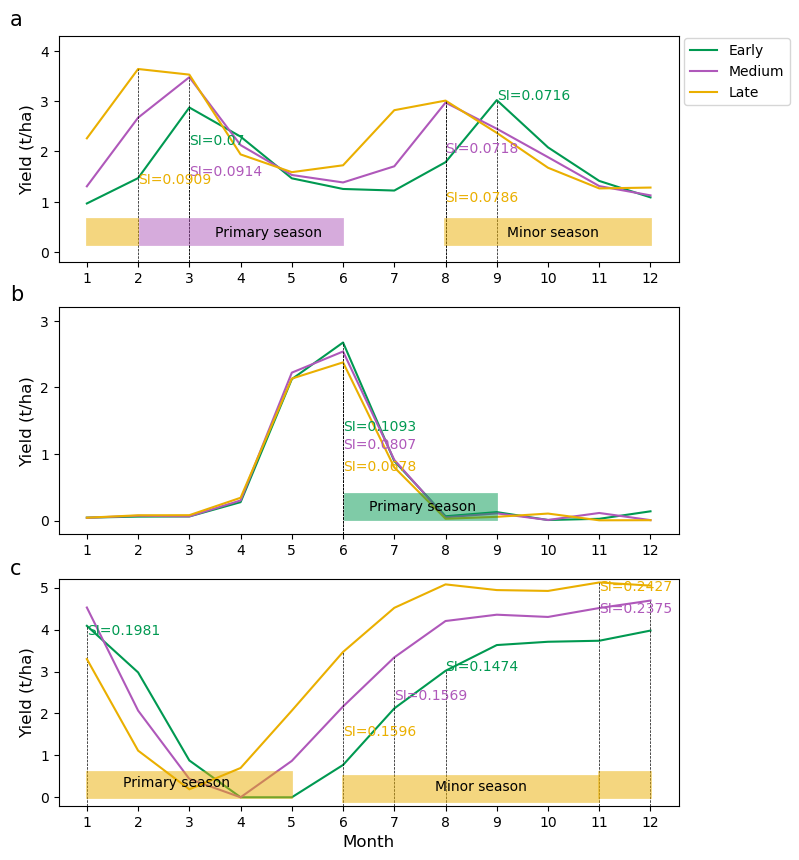

In [141]:
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\wfer\\"
type_colors=['#009951','#AF58BA','#EAAF00']
label=['Early','Medium','Late']
cul=['.1','0','1']
fig, ax = plt.subplots(3,1, figsize=(8,10))
#Tropical Bimodel
df0=df.loc[df['SIMUNIT']==21599]
text_pos=[[9,1.5],[6.9,1.0],[10.9,1.3]]
for c in range(3):
    #season 1
    df1=df0[[col for col in df0.columns if 'm'+cul[c] in col]].mean(axis=0).tolist()
    ax[0].plot(range(1,13),df1,color=type_colors[c],label=label[c])
    df1=df1[:8]
    mxvalue=max(df1)
    mon=df1.index(mxvalue)+1
    ax[0].plot([mon,mon],[-0.2,mxvalue],linestyle='dashed',color='black',linewidth=0.5)
    #if mon==12: mon=1
    #ax.plot([mon,mon+3+c],[0+c*0.2]*2,color=type_colors[c],linewidth=10,alpha=0.5)
    df2=df0['m'+cul[c]+'s'+str(mon).zfill(2)].values
    si=round(df2.mean()**2/(100*df2.std()),4)
    ax[0].text(mon,5-mxvalue,"SI="+str(si),color=type_colors[c])
c=1
ax[0].plot([mon+0.30,mon+3+c-0.25],[0.2+c*0.2]*2,color=type_colors[c],linewidth=20,alpha=0.5)
ax[0].text(3.5,0.3,"Primary season")
#season 2  
for c in range(3):
    #list(set([i for i in range(1,13)])-set([i for i in range(mon,mon+5)])) #other months expect primary season
    df1=df0[[col for col in df0.columns if 'm'+cul[c] in col]].mean(axis=0).tolist()
    sea1_mon=[i-1 for i in range(mon,mon+3+c)] #season 1 month
    df1=[0 if i in sea1_mon else df1[i] for i in range(12)]
    mxvalue1=max(df1)
    mon1=df1.index(mxvalue1)+1
    ax[0].plot([mon1,mon1],[-0.2,mxvalue1],linestyle='dashed',color='black',linewidth=0.5)
    #if mon==12: mon=1
    #ax.plot([mon,mon+3+c],[0+c*0.2]*2,color=type_colors[c],linewidth=10,alpha=0.5)
    df2=df0['m'+cul[c]+'s'+str(mon1).zfill(2)].values
    si=round(df2.mean()**2/(100*df2.std()),4)
    ax[0].text(mon1,mxvalue1-c,"SI="+str(si),color=type_colors[c])
c=2
ax[0].plot([8+0.25,8+3+1-0.25],[0+2*0.2]*2,color=type_colors[c],linewidth=20,alpha=0.5)
ax[0].plot([1.25,2-0.25],[0+2*0.2]*2,color=type_colors[c],linewidth=20,alpha=0.5)
ax[0].text(9.2,0.3,"Minor season")

ax[0].set_ylim([-0.2,4.3])   
ax[0].set_xticks([i for i in range(1,13)],[i for i in range(1,13)])
ax[0].set_yticks([i for i in range(5)],[i for i in range(5)])
#ax[0].set_xlabel("Month",fontsize=12)
ax[0].set_ylabel("Yield (t/ha)",fontsize=12)
ax[0].legend(bbox_to_anchor=(1.19, 1.02), loc='upper right',fontsize=10)

##Temporal Unimodel low rainfall
df0=df.loc[df['SIMUNIT']==58260] 
for c in range(3):
    #season 1
    df1=df0[[col for col in df0.columns if 'm'+cul[c] in col]].mean(axis=0).tolist()
    ax[1].plot(range(1,13),df1,color=type_colors[c],label=label[c])
    mxvalue=max(df1)
    mon=df1.index(mxvalue)+1
    ax[1].plot([mon,mon],[-0.2,mxvalue],linestyle='dashed',color='black',linewidth=0.5)
    #if mon==12: mon=1
    #ax.plot([mon,mon+3+c],[0+c*0.2]*2,color=type_colors[c],linewidth=10,alpha=0.5)
    df2=df0['m'+cul[c]+'s'+str(mon).zfill(2)].values
    si=round(df2.mean()**2/(100*df2.std()),4)
    ax[1].text(mon,mxvalue/0.5-4,"SI="+str(si),color=type_colors[c])
c=0
ax[1].plot([mon+0.30,mon+3+c-0.25],[0.2+c*0.2]*2,color=type_colors[c],linewidth=20,alpha=0.5)
ax[1].text(6.5,0.15,"Primary season")

ax[1].set_ylim([-0.2,3.2])   
ax[1].set_xticks([i for i in range(1,13)],[i for i in range(1,13)])
ax[1].set_yticks([i for i in range(4)],[i for i in range(4)])
#ax[1].set_xlabel("Month",fontsize=12)
ax[1].set_ylabel("Yield (t/ha)",fontsize=12)

##Temporal Unimodel high rainfall with long period
df0=df.loc[df['SIMUNIT']==162680]
for c in range(3):
    #season 1
    df1=df0[[col for col in df0.columns if 'm'+cul[c] in col]].mean(axis=0).tolist()
    ax[2].plot(range(1,13),df1,color=type_colors[c],label=label[c])
    mxvalue=max(df1)
    mon=df1.index(mxvalue)+1
    ax[2].plot([mon,mon],[-0.2,mxvalue],linestyle='dashed',color='black',linewidth=0.5)
    #if mon==12: mon=1
    #ax.plot([mon,mon+3+c],[0+c*0.2]*2,color=type_colors[c],linewidth=10,alpha=0.5)
    df2=df0['m'+cul[c]+'s'+str(mon).zfill(2)].values
    si=round(df2.mean()**2/(100*df2.std()),4)
    if c==1:
        ax[2].text(mon-1,mxvalue-0.3,"SI="+str(si),color=type_colors[c])
    else:
        ax[2].text(mon,mxvalue-0.2,"SI="+str(si),color=type_colors[c])
c=2
ax[2].plot([mon+0.25,mon+1-0.25],[0.3]*2,color=type_colors[c],linewidth=20,alpha=0.5)
ax[2].plot([1+0.25,4+1-0.25],[0.3]*2,color=type_colors[c],linewidth=20,alpha=0.5)
ax[2].text(1.7,0.25,"Primary season")
#season 2  
for c in range(3):
    #list(set([i for i in range(1,13)])-set([i for i in range(mon,mon+5)])) #other months expect primary season
    df1=df0[[col for col in df0.columns if 'm'+cul[c] in col]].mean(axis=0).tolist()
    sea1_mon=[i-1 for i in range(mon,mon+3+c)] #season 1 month
    sea1_mon=[x%12 for x in sea1_mon]+[i for i in range(mon-3-c,mon+1)]
    df1=[0 if i in sea1_mon else df1[i] for i in range(12)]
    mxvalue1=max(df1)
    mon1=df1.index(mxvalue1)+1
    ax[2].plot([mon1,mon1],[-0.2,mxvalue1],linestyle='dashed',color='black',linewidth=0.5)
    #if mon==12: mon=1
    #ax.plot([mon,mon+3+c],[0+c*0.2]*2,color=type_colors[c],linewidth=10,alpha=0.5)
    df2=df0['m'+cul[c]+'s'+str(mon1).zfill(2)].values
    si=round(df2.mean()**2/(100*df2.std()),4)
    ax[2].text(mon1,mxvalue1-c,"SI="+str(si),color=type_colors[c])
c=2
ax[2].plot([mon1+0.25,mon1+c+3-0.25],[0.2]*2,color=type_colors[c],linewidth=20,alpha=0.5)
#ax.plot([1.25,2-0.25],[0+2*0.2]*2,color=type_colors[c],linewidth=20,alpha=0.5)
ax[2].text(7.8,0.15,"Minor season")

ax[2].set_ylim([-0.2,5.2])   
ax[2].set_xticks([i for i in range(1,13)],[i for i in range(1,13)])
ax[2].set_yticks([i for i in range(6)],[i for i in range(6)])
ax[2].set_xlabel("Month",fontsize=12)
ax[2].set_ylabel("Yield (t/ha)",fontsize=12)
ax[0].text(-0.5,4.5,"a",fontsize=15)
ax[1].text(-0.5,3.3,"b",fontsize=15)
ax[2].text(-0.5,5.3,"c",fontsize=15)
fig.savefig(fig_dir+"\\S1_IdentifySeasons.png",format="png",dpi=300, bbox_inches='tight', pad_inches=0)

In [4]:
fer="wfer_wa38hi40"
df=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_"+fer+".csv")

Text(0, 0.5, 'Yield (t/ha)')

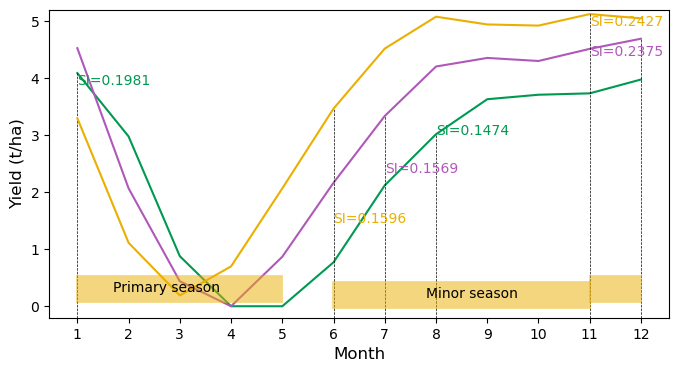

In [135]:
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\wfer\\"
type_colors=['#009951','#AF58BA','#EAAF00']
label=['Early','Medium','Late']
cul=['.1','0','1']
df0=df.loc[df['SIMUNIT']==162680]   #single season 162680
fig, ax = plt.subplots(figsize=(8,4))
text_pos=[[9,1.5],[6.9,1.0],[10.9,1.3]]
for c in range(3):
    #season 1
    df1=df0[[col for col in df0.columns if 'm'+cul[c] in col]].mean(axis=0).tolist()
    ax.plot(range(1,13),df1,color=type_colors[c],label=label[c])
    mxvalue=max(df1)
    mon=df1.index(mxvalue)+1
    ax.plot([mon,mon],[-0.2,mxvalue],linestyle='dashed',color='black',linewidth=0.5)
    #if mon==12: mon=1
    #ax.plot([mon,mon+3+c],[0+c*0.2]*2,color=type_colors[c],linewidth=10,alpha=0.5)
    df2=df0['m'+cul[c]+'s'+str(mon).zfill(2)].values
    si=round(df2.mean()**2/(100*df2.std()),4)
    if c==1:
        ax.text(mon-1,mxvalue-0.3,"SI="+str(si),color=type_colors[c])
    else:
        ax.text(mon,mxvalue-0.2,"SI="+str(si),color=type_colors[c])
c=2
ax.plot([mon+0.25,mon+1-0.25],[0.3]*2,color=type_colors[c],linewidth=20,alpha=0.5)
ax.plot([1+0.25,4+1-0.25],[0.3]*2,color=type_colors[c],linewidth=20,alpha=0.5)
ax.text(1.7,0.25,"Primary season")

#season 2  
for c in range(3):
    #list(set([i for i in range(1,13)])-set([i for i in range(mon,mon+5)])) #other months expect primary season
    df1=df0[[col for col in df0.columns if 'm'+cul[c] in col]].mean(axis=0).tolist()
    sea1_mon=[i-1 for i in range(mon,mon+3+c)] #season 1 month
    sea1_mon=[x%12 for x in sea1_mon]+[i for i in range(mon-3-c,mon+1)]
    df1=[0 if i in sea1_mon else df1[i] for i in range(12)]
    mxvalue1=max(df1)
    mon1=df1.index(mxvalue1)+1
    ax.plot([mon1,mon1],[-0.2,mxvalue1],linestyle='dashed',color='black',linewidth=0.5)
    #if mon==12: mon=1
    #ax.plot([mon,mon+3+c],[0+c*0.2]*2,color=type_colors[c],linewidth=10,alpha=0.5)
    df2=df0['m'+cul[c]+'s'+str(mon1).zfill(2)].values
    si=round(df2.mean()**2/(100*df2.std()),4)
    ax.text(mon1,mxvalue1-c,"SI="+str(si),color=type_colors[c])
c=2
ax.plot([mon1+0.25,mon1+c+3-0.25],[0.2]*2,color=type_colors[c],linewidth=20,alpha=0.5)
#ax.plot([1.25,2-0.25],[0+2*0.2]*2,color=type_colors[c],linewidth=20,alpha=0.5)
ax.text(7.8,0.15,"Minor season")

ax.set_ylim([-0.2,5.2])   
ax.set_xticks([i for i in range(1,13)],[i for i in range(1,13)])
ax.set_yticks([i for i in range(6)],[i for i in range(6)])
ax.set_xlabel("Month",fontsize=12)
ax.set_ylabel("Yield (t/ha)",fontsize=12)
#ax.legend(bbox_to_anchor=(1.19, 1.02), loc='upper right',fontsize=10)
#fig.savefig(fig_dir+"\\S1_IdentifySeasons.png",format="png",dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
# Create a figure with GridSpec
# Bar potential benefits
bar=axes[0].barh("Optimum Cultivars\nwith optimum sow",potentialbeni['optimSeedProdOptimSow_se1'].mean(),color='green')
ax1.barh("Optimum Cultivars\nwith optimum sow",potentialbeni['optimSeedProdOptimSow_se2'].mean(),
            left=potentialbeni['optimSeedProdOptimSow_se1'].mean(),
            xerr=potentialbeni[['optimSeedProdOptimSow_se1','optimSeedProdOptimSow_se1']].sum(axis=1).std(),
            color='lightgreen')
ax1.text(50,-0.25,'Primary season',ha='center',va='center',color='white')
ax1.text(120,-0.25,'Minor season',ha='center',va='center',color='black')

ax1.barh("Optimum Cultivars\nWith fixed sow",potentialbeni['optimSeedProdOptimFixedSow_se1'].mean(),color='blue')
ax1.barh("Optimum Cultivars\nWith fixed sow",potentialbeni['optimSeedProdOptimFixedSow_se2'].mean(),
            left=potentialbeni['optimSeedProdOptimFixedSow_se1'].mean(),
            xerr=potentialbeni[['optimSeedProdOptimFixedSow_se1','optimSeedProdOptimFixedSow_se2']].sum(axis=1).std(),
            color='lightblue')

ax1.barh("Reference\nMean in cultivars",potentialbeni['meanProdOptimFixedSow_se1'].mean(),color='purple')
ax1.barh("Reference\nMean in cultivars",potentialbeni['meanProdOptimFixedSow_se2'].mean(),
            left=potentialbeni['meanProdOptimFixedSow_se1'].mean(),
            xerr=potentialbeni[['meanProdOptimFixedSow_se1','meanProdOptimFixedSow_se2']].sum(axis=1).std(),
            color='violet')
ax1.barh("FAO reported\nmean in 2017-2022",potentialbeni['FAO2011-2022'].mean(),
            xerr=potentialbeni['FAO2011-2022'].std(),color='lightgrey')
ax1.set_xlabel("Production (MT)",fontsize=12)
ax1.text(10,2.75,'Seasons not divided', color='black')

#Scatter and fit line - production benefits with market segmentation
ax2.plot([1, 2, 3], [6, 5, 4])
def func(x, a, n, k):  #y(x)=7*(x**n)/(k**n)+(x**n)
    return -a*(x**n)/((k**n)+(x**n))
xdata = culsen['cul'].values
ydata = culsen['prod_ch']
popt, pcov = curve_fit(func, xdata, ydata)  # Fit the curve
a, n, k = popt # Extract the optimized parameters
ax2.scatter(ydata, xdata, label='Data',s=15,alpha=0.5) # Extract the optimized parameters
x_fit = np.linspace(0, 600, 100)
ax2.plot(func(x_fit, -6.7, n, k), x_fit, 'r-', label='Fit')
ax2.set_ylim([0,550])
ax2.set_xlabel("Change in production mean (%)",fontsize=12)
ax2.set_ylabel("Number of clustered seed market",fontsize=12)

#Scatter and fit line - cv benefit with martket segmentation
ax3.plot([1, 2, 3], [5, 5, 5])
def func(x, a, n, k):  #y(x)=7*(x**n)/(k**n)+(x**n)
    return a*(x**n)/((k**n)+(x**n))
xdata = culsen['cul'].values
ydata = culsen['cv_ch']
popt, pcov = curve_fit(func, xdata, ydata)# Fit the curve
a, n, k = popt# Extract the optimized parameters
ax3.scatter(ydata, xdata, label='Data',s=15,alpha=0.5)
x_fit = np.linspace(0, 800, 100)
ax3.plot(func(x_fit, -16.0, 0.05,5000), x_fit, 'r-', label='Fit')
ax3.set_xlim([-9,0])
ax3.set_ylim([0,550])
ax3.set_yticklabels([])
ax3.set_xlabel("Change in production variability (%)",fontsize=12)
gs.update(wspace=0.2)  # Increase overall spacing
ax2.set_position([ax2.get_position().x0 + 0.03, ax2.get_position().y0, 
                  ax2.get_position().width, ax2.get_position().height])  # Shift middle subplot

#Add yellow box for choosing the cluster parameters and number of market
rect = patches.Rectangle((0.428, 0.16), 0.472, 0.05, transform=fig.transFigure, 
                         linewidth=0.5, edgecolor='black', facecolor='yellow',alpha=0.3)
fig.add_artist(rect)
rect = patches.Rectangle((0.428, 0.18), 0.472, 0.001, transform=fig.transFigure, 
                         linewidth=1,linestyle=':', edgecolor='black', facecolor='none')
fig.add_artist(rect)

plt.show()

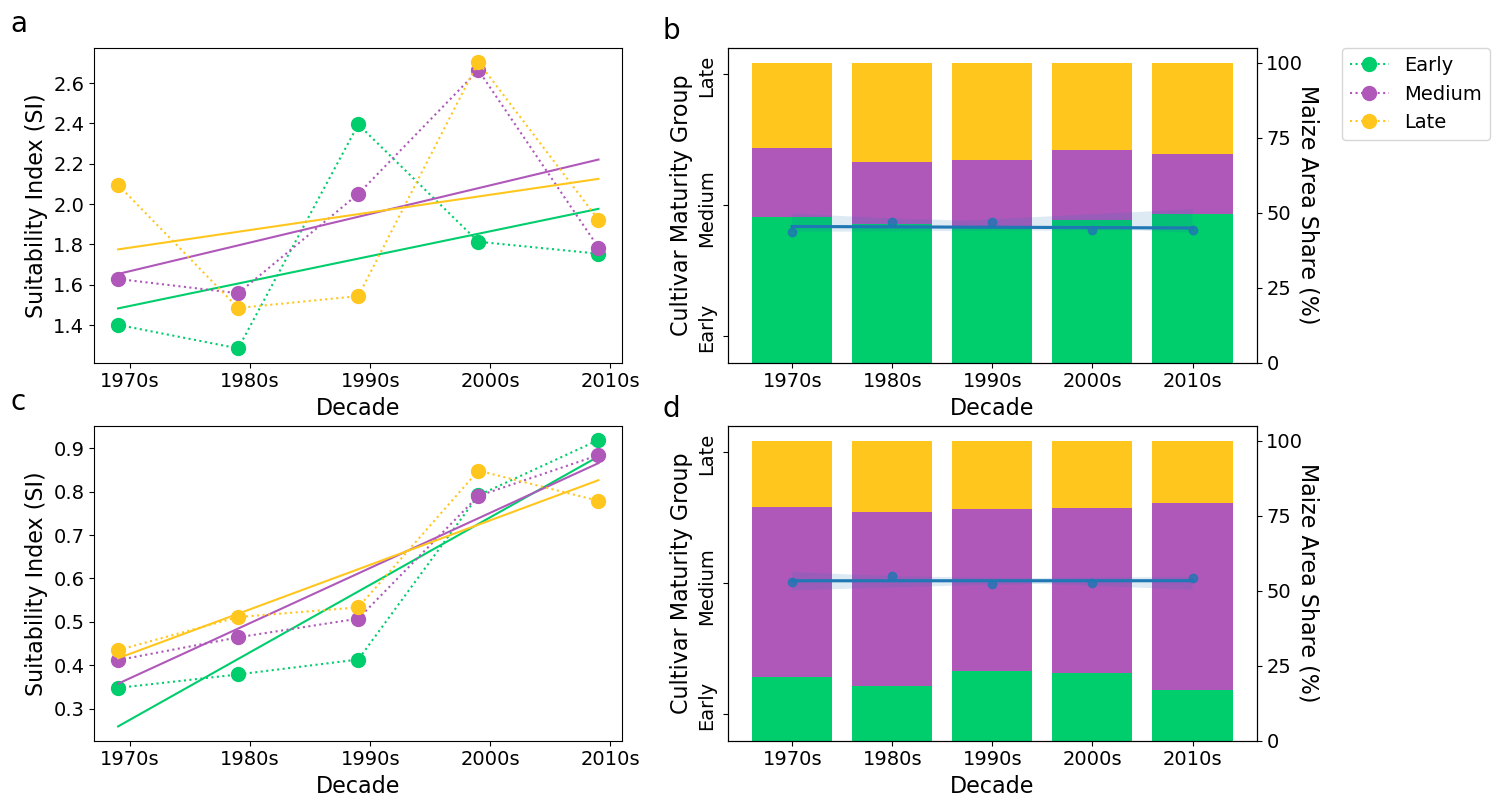

In [43]:
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\MS\\wfer\\"
fig, ax = plt.subplots(2, 2, figsize=(15,9))
#colors=["#00CD6C", "#AF58BA", "#FFC61E"]
type_colors=["#00CD6C", "#AF58BA", "#FFC61E"]
label=['Early','Medium','Late']
for cul in range(3):
    for se in range(2):
        #SI Change  - yld
        y = yld.loc[(yld.matu==cul+1)&(yld.sea==se+1),[str(x) for x in range(1971,2022)]]
        y = pd.DataFrame(y.values[0])
        #plt.plot()
        y = (y[0].groupby(np.arange(len(y)) // 10).mean())**2/(100*y[0].groupby(np.arange(len(y)) // 10).std())
        y = y.dropna()
        x = list(range(1975,2021,10))
        ax[se,0].plot(x,y,marker='o',markersize=10,color=type_colors[cul],linestyle=':', label=label[cul]) #,
        #trend
        z = np.polyfit(x,y,1) #fit a 1st-degree polynomial (linear)
        p = np.poly1d(z)
        ax[se,0].plot(x, p(x), "-", color=type_colors[cul])
        ax[se,0].set_xticks([1976,1986,1996,2006,2016])
        ax[se,0].set_xticklabels(["1970s","1980s","1990s","2000s","2010s"],fontsize=14)
        ax[se,0].set_xlabel("Decade",fontsize=16)
        ax[se,0].set_ylabel("Suitability Index (SI)",fontsize=16)
        ax[se,0].tick_params(axis='both', which='major', labelsize=14)

for se in range(2):
    period=["se"+str(se+1)+"c_"+str(p) for p in range(5)]
    data=pd.DataFrame(columns=['culvalue','E','M','L'])
    temp=df_area[period+['PhysicalArea']].fillna(0)
    data['culvalue']=[sum(temp[c]*temp['PhysicalArea'])/temp['PhysicalArea'].sum() for c in temp.columns[:5]]
    for p in range(5):
        data.iloc[p,1:]=(temp[[period[p],'PhysicalArea']].groupby(period[p]).sum()*100/temp['PhysicalArea'].sum()).reset_index()['PhysicalArea'].tolist()

    ax1=ax[se,1].twinx()
    #Bar
    ax[se,1].bar(list(range(5)),data["E"].values,color=type_colors[0],label='Early')
    ax[se,1].bar(list(range(5)),data["M"].values,bottom=data['E'].values,color=type_colors[1],label="Middle")
    ax[se,1].bar(list(range(5)),data["L"].values,bottom=data[['E','M']].sum(1).values,color=type_colors[2],label="Later")

    sns.regplot(x=list(range(5)),y=data['culvalue'].tolist(),ax=ax1)
    ax[se,1].yaxis.set_ticks_position('right')
    ax1.yaxis.set_ticks_position('left')
    ax1.set_ylim([-1.2,1.2])
    ax1.set_yticks([-1,0,1],["   ","    ","    "],rotation=90,fontsize=14)
    ax[se,1].text(-0.95,5,"Early",rotation=90,fontsize=14)
    ax[se,1].text(-0.95,40,"Medium",rotation=90,fontsize=14)
    ax[se,1].text(-0.95,90,"Late",rotation=90,fontsize=14)
    #for pos,label in zip([-0.5,0.5,1.5],):
    #    ax1.text(pos,1965,label,rotation=90,fontsize=14)
    #ax1.set_yticklabels(["Early","Middle","Later"],rotation=90)
    ax[se,1].set_yticks([0,25,50,75,100])
    ax1.set_ylabel("Maize Area Share (%)",fontsize=16, rotation=-90, labelpad=45)
    ax[se,1].set_ylabel("Cultivar Maturity Group",fontsize=16,labelpad=25)
    ax[se,1].set_xticks([0,1,2,3,4],["1970s","1980s","1990s","2000s","2010s"])
    ax[se,1].set_xlabel("Decade", fontsize=16)
    ax[se,1].tick_params(axis='both', which='major', labelsize=14)

ax[0,0].legend(bbox_to_anchor=(2.66, 1.03), loc='upper right',fontsize=14)
ax[0,0].text(1966,ax[0,0].get_ylim()[1]+(ax[0,0].get_ylim()[1]-ax[0,0].get_ylim()[0])/20,"a",fontsize=20)
ax[1,0].text(1966,ax[1,0].get_ylim()[1]+(ax[1,0].get_ylim()[1]-ax[1,0].get_ylim()[0])/20,"c",fontsize=20)
ax[0,1].text(-1.3,108,"b",fontsize=20)
ax[1,1].text(-1.3,108,"d",fontsize=20)   
fig.savefig(fig_dir+"MS1_mz_cul_SI_AreaSharing_change_"+fer+G1+".png",format="png",dpi=300,bbox_inches='tight', pad_inches=0)
fig.savefig(fig_dir+"MS1_mz_cul_SI_AreaSharing_change_"+fer+G1+".pdf",format="pdf",dpi=300,bbox_inches='tight', pad_inches=0)

In [ ]:
#Plotting
fig, ax = plt.subplots(1, 2, figsize=(15,4.5))